# Experiments: Cluster and K3S

In [2]:
# Imports
import os
import re
import sys
import ast
import time
import pathlib
import datetime
import itertools
import textwrap
import numpy as np
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Global variables

# Paths
global_res_dir = "./results"
assets_path = "./assets"

In [4]:
# ssh and scp functions with arguements
ssh_with_args = "ssh -o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no"
scp_with_args = "scp -o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no"

## Experiment 1: Measure CPU & RAM usage with K3S

In [5]:
# Experiment setup
experiment_name = "K3S CPU and RAM usage"
timestamp = timestamp=datetime.datetime.now() # Current timestamp

iterations = 10
ssh_infos = ["pptc@192.168.88.3", "pptc@192.168.88.17", "pptc@192.168.88.3"] + ["pptc@192.168.88.17"] * 9
device_states = ["uninstall", "server 0", "worker"] + ["server "+str(i) for i in range(1, 10)]
count_for_usage_script = 20

df = pd.DataFrame()
df["SSH info"] = ssh_infos
df["Device state"] = device_states
display(df)

# df = df[df.index == 2].reset_index()


,SSH info,Device state
0,pptc@192.168.88.3,uninstall
1,pptc@192.168.88.17,server 0
2,pptc@192.168.88.3,worker
3,pptc@192.168.88.17,server 1
4,pptc@192.168.88.17,server 2
5,pptc@192.168.88.17,server 3
6,pptc@192.168.88.17,server 4
7,pptc@192.168.88.17,server 5
8,pptc@192.168.88.17,server 6
9,pptc@192.168.88.17,server 7


In [39]:
# Experiment path
exp_folder_name = experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
# exp_folder_name = experiment_name.replace(' ', '_') + "_20240814T191553"
curr_exp_dir = global_res_dir + "/" + exp_folder_name
curr_exp_raw_dir = curr_exp_dir + "/raw_results"
curr_exp_res_dir = curr_exp_dir + "/results"

# Create results dir
path = Path(curr_exp_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(curr_exp_raw_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(curr_exp_res_dir)
path.mkdir(parents=True, exist_ok=True)

# Remote path
remote_exp_results_dir = "~/" + exp_folder_name + "/results"
remote_exp_cpu_usage_dir = remote_exp_results_dir + "/cpu_usage"
remote_exp_ram_usage_dir = remote_exp_results_dir + "/ram_usage"
remote_exp_scripts_dir = "~/" + exp_folder_name + "/scripts"

print(df.shape[0])

# Perform experiement
for i in range(df.shape[0]):
    ssh_info = df.loc[i, "SSH info"]
    dev_state = df.loc[i, "Device state"]

    print(f"Prepare next config:\n\tSSH info: {ssh_info}\n\tDev_state: {dev_state}\n\t\n")
    time.sleep(2)
    v = input("Press ENTER to run the benchmark")
    print(f"Value : {v}")
    if v == "s": # stop
        break
    print("Run benchmark...")

    # Copy scripts on remote device
    !{ssh_with_args} {ssh_info} "mkdir -p ~/{exp_folder_name}"
    !{scp_with_args} -r scripts/ {ssh_info}:~/{exp_folder_name}

    # Create remote workspace
    !{ssh_with_args} {ssh_info} "mkdir -p {remote_exp_cpu_usage_dir}; mkdir -p {remote_exp_ram_usage_dir}"    

    # Remote paths
    cpu_usage_remote_file = remote_exp_cpu_usage_dir + "/results_cpu_usage_" + ssh_info + "_" + dev_state.replace(' ', '_') + ".txt"
    ram_usage_remote_file = remote_exp_ram_usage_dir + "/results_ram_usage_" + ssh_info + "_" + dev_state.replace(' ', '_') + ".txt"

    # Remote for cpu and ram usage
    !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# DEVICE_STATE={dev_state}\n# COUNT={count_for_usage_script}\n\" > {cpu_usage_remote_file}"
    !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# DEVICE_STATE={dev_state}\n# COUNT={count_for_usage_script}\n\" > {ram_usage_remote_file}"

    for i in range(iterations):
        print(f'Iteration {i}')
        !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {cpu_usage_remote_file}"
        !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {ram_usage_remote_file}"

        print("Start CPU and RAM usage scripts")

        cpu_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/cpu_usage_script.sh {count_for_usage_script} {cpu_usage_remote_file} 0"', shell=True)
        ram_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/ram_usage_script.sh {count_for_usage_script} {ram_usage_remote_file} 0"', shell=True)
        time.sleep(count_for_usage_script)

        print("Sleep 5s")
        time.sleep(5) # To have more usage measures

    print("Retrieve usage results and remove remote workspace")
    !{scp_with_args} -r {ssh_info}:{remote_exp_cpu_usage_dir} {curr_exp_raw_dir}
    !{scp_with_args} -r {ssh_info}:{remote_exp_ram_usage_dir} {curr_exp_raw_dir}

    !# Remove remote workspace
    !{ssh_with_args} {ssh_info} "rm -rf ~/{exp_folder_name}"
    


12
Prepare next config:
	SSH info: pptc@192.168.88.3
	Dev_state: uninstall
	

Value : 
Run benchmark...
cpu_usage_script.sh                           100% 1189   587.8KB/s   00:00    
ram_usage_script.sh                           100% 1253   792.5KB/s   00:00    
Iteration 0
Start CPU and RAM usage scripts


Sleep 5s
Iteration 1
Start CPU and RAM usage scripts


Sleep 5s
Iteration 2
Start CPU and RAM usage scripts


Sleep 5s
Iteration 3
Start CPU and RAM usage scripts


Sleep 5s
Iteration 4
Start CPU and RAM usage scripts


Sleep 5s
Iteration 5
Start CPU and RAM usage scripts


Sleep 5s
Iteration 6
Start CPU and RAM usage scripts


Sleep 5s
Iteration 7
Start CPU and RAM usage scripts


Sleep 5s
Iteration 8
Start CPU and RAM usage scripts


Sleep 5s
Iteration 9
Start CPU and RAM usage scripts


Sleep 5s
Retrieve usage results and remove remote workspace
results_cpu_usage_pptc@192.168.88.3_uninstall 100% 8842     1.6MB/s   00:00    
results_ram_usage_pptc@192.168.88.3_uninstall 100%   11KB   2.1MB/s   00:00    
Prepare next config:
	SSH info: pptc@192.168.88.17
	Dev_state: server 0
	

Value : 
Run benchmark...
cpu_usage_script.sh                           100% 1189   582.4KB/s   00:00    
ram_usage_script.sh                           100% 1253   716.4KB/s   00:00    
Iteration 0
Start CPU and RAM usage scripts


Sleep 5s
Iteration 1
Start CPU and RAM usage scripts


Sleep 5s
Iteration 2
Start CPU and RAM usage scripts


Sleep 5s
Iteration 3
Start CPU and RAM usage scripts


Sleep 5s
Iteration 4
Start CPU and RAM usage scripts


Sleep 5s
Iteration 5
Start CPU and RAM usage scripts


Sleep 5s
Iteration 6
Start CPU and RAM usage scripts


Sleep 5s
Iteration 7
Start CPU and RAM usage scripts


Sleep 5s
Iteration 8
Start CPU and RAM usage scripts


Sleep 5s
Iteration 9
Start CPU and RAM usage scripts


Sleep 5s
Retrieve usage results and remove remote workspace
results_cpu_usage_pptc@192.168.88.17_server_0 100% 8842     1.5MB/s   00:00    
results_ram_usage_pptc@192.168.88.17_server_0 100%   11KB   2.7MB/s   00:00    
Prepare next config:
	SSH info: pptc@192.168.88.3
	Dev_state: worker
	

Value : 
Run benchmark...
cpu_usage_script.sh                           100% 1189   531.4KB/s   00:00    
ram_usage_script.sh                           100% 1253   614.8KB/s   00:00    
Iteration 0
Start CPU and RAM usage scripts


Sleep 5s
Iteration 1
Start CPU and RAM usage scripts


Sleep 5s
Iteration 2
Start CPU and RAM usage scripts


Sleep 5s
Iteration 3
Start CPU and RAM usage scripts


Sleep 5s
Iteration 4
Start CPU and RAM usage scripts


Sleep 5s
Iteration 5
Start CPU and RAM usage scripts


Sleep 5s
Iteration 6
Start CPU and RAM usage scripts


Sleep 5s
Iteration 7
Start CPU and RAM usage scripts


Sleep 5s
Iteration 8
Start CPU and RAM usage scripts


Sleep 5s
Iteration 9
Start CPU and RAM usage scripts


Sleep 5s
Retrieve usage results and remove remote workspace
results_cpu_usage_pptc@192.168.88.3_worker.tx 100% 8839   706.1KB/s   00:00    
results_ram_usage_pptc@192.168.88.3_worker.tx 100%   11KB 508.1KB/s   00:00    
Prepare next config:
	SSH info: pptc@192.168.88.17
	Dev_state: server 1
	

Value : 
Run benchmark...
cpu_usage_script.sh                           100% 1189   687.2KB/s   00:00    
ram_usage_script.sh                           100% 1253   707.1KB/s   00:00    
Iteration 0
Start CPU and RAM usage scripts


Sleep 5s
Iteration 1
Start CPU and RAM usage scripts


Sleep 5s
Iteration 2
Start CPU and RAM usage scripts


Sleep 5s
Iteration 3
Start CPU and RAM usage scripts


Sleep 5s
Iteration 4
Start CPU and RAM usage scripts


Sleep 5s
Iteration 5
Start CPU and RAM usage scripts


Sleep 5s
Iteration 6
Start CPU and RAM usage scripts


Sleep 5s
Iteration 7
Start CPU and RAM usage scripts


Sleep 5s
Iteration 8
Start CPU and RAM usage scripts


Sleep 5s
Iteration 9
Start CPU and RAM usage scripts


Sleep 5s
Retrieve usage results and remove remote workspace
results_cpu_usage_pptc@192.168.88.17_server_1 100% 9042     2.6MB/s   00:00    
results_ram_usage_pptc@192.168.88.17_server_1 100%   11KB   2.6MB/s   00:00    
Prepare next config:
	SSH info: pptc@192.168.88.17
	Dev_state: server 2
	

Value : 
Run benchmark...
cpu_usage_script.sh                           100% 1189   737.3KB/s   00:00    
ram_usage_script.sh                           100% 1253   926.3KB/s   00:00    
Iteration 0
Start CPU and RAM usage scripts


Sleep 5s
Iteration 1
Start CPU and RAM usage scripts


Sleep 5s
Iteration 2
Start CPU and RAM usage scripts


Sleep 5s
Iteration 3
Start CPU and RAM usage scripts


Sleep 5s
Iteration 4
Start CPU and RAM usage scripts


Sleep 5s
Iteration 5
Start CPU and RAM usage scripts


Sleep 5s
Iteration 6
Start CPU and RAM usage scripts


Sleep 5s
Iteration 7
Start CPU and RAM usage scripts


Sleep 5s
Iteration 8
Start CPU and RAM usage scripts


Sleep 5s
Iteration 9
Start CPU and RAM usage scripts


Sleep 5s
Retrieve usage results and remove remote workspace
results_cpu_usage_pptc@192.168.88.17_server_2 100% 9042     1.1MB/s   00:00    
results_ram_usage_pptc@192.168.88.17_server_2 100%   11KB   3.1MB/s   00:00    
Prepare next config:
	SSH info: pptc@192.168.88.17
	Dev_state: server 3
	

Value : 
Run benchmark...
cpu_usage_script.sh                           100% 1189   344.9KB/s   00:00    
ram_usage_script.sh                           100% 1253   819.4KB/s   00:00    
Iteration 0
Start CPU and RAM usage scripts


Sleep 5s
Iteration 1
Start CPU and RAM usage scripts


Sleep 5s
Iteration 2
Start CPU and RAM usage scripts


Sleep 5s
Iteration 3
Start CPU and RAM usage scripts


Sleep 5s
Iteration 4
Start CPU and RAM usage scripts


Sleep 5s
Iteration 5
Start CPU and RAM usage scripts


Sleep 5s
Iteration 6
Start CPU and RAM usage scripts


Sleep 5s
Iteration 7
Start CPU and RAM usage scripts


Sleep 5s
Iteration 8
Start CPU and RAM usage scripts


Sleep 5s
Iteration 9
Start CPU and RAM usage scripts


Sleep 5s
Retrieve usage results and remove remote workspace
results_cpu_usage_pptc@192.168.88.17_server_3 100% 9242     1.8MB/s   00:00    
results_ram_usage_pptc@192.168.88.17_server_3 100%   11KB   2.7MB/s   00:00    
Prepare next config:
	SSH info: pptc@192.168.88.17
	Dev_state: server 4
	

Value : 
Run benchmark...
cpu_usage_script.sh                           100% 1189   549.9KB/s   00:00    
ram_usage_script.sh                           100% 1253   802.8KB/s   00:00    
Iteration 0
Start CPU and RAM usage scripts


Sleep 5s
Iteration 1
Start CPU and RAM usage scripts


Sleep 5s
Iteration 2
Start CPU and RAM usage scripts


Sleep 5s
Iteration 3
Start CPU and RAM usage scripts


Sleep 5s
Iteration 4
Start CPU and RAM usage scripts


Sleep 5s
Iteration 5
Start CPU and RAM usage scripts


Sleep 5s
Iteration 6
Start CPU and RAM usage scripts


Sleep 5s
Iteration 7
Start CPU and RAM usage scripts


Sleep 5s
Iteration 8
Start CPU and RAM usage scripts


Sleep 5s
Iteration 9
Start CPU and RAM usage scripts


Sleep 5s
Retrieve usage results and remove remote workspace
results_cpu_usage_pptc@192.168.88.17_server_4 100% 9442     2.2MB/s   00:00    
results_ram_usage_pptc@192.168.88.17_server_4 100%   11KB   1.9MB/s   00:00    
Prepare next config:
	SSH info: pptc@192.168.88.17
	Dev_state: server 5
	

Value : 
Run benchmark...
cpu_usage_script.sh                           100% 1189   725.4KB/s   00:00    
ram_usage_script.sh                           100% 1253   922.2KB/s   00:00    
Iteration 0
Start CPU and RAM usage scripts


Sleep 5s
Iteration 1
Start CPU and RAM usage scripts


Sleep 5s
Iteration 2
Start CPU and RAM usage scripts


Sleep 5s
Iteration 3
Start CPU and RAM usage scripts


Sleep 5s
Iteration 4
Start CPU and RAM usage scripts


Sleep 5s
Iteration 5
Start CPU and RAM usage scripts


Sleep 5s
Iteration 6
Start CPU and RAM usage scripts


Sleep 5s
Iteration 7
Start CPU and RAM usage scripts


Sleep 5s
Iteration 8
Start CPU and RAM usage scripts


Sleep 5s
Iteration 9
Start CPU and RAM usage scripts


Sleep 5s
Retrieve usage results and remove remote workspace
results_cpu_usage_pptc@192.168.88.17_server_5 100% 9642     2.0MB/s   00:00    
results_ram_usage_pptc@192.168.88.17_server_5 100%   11KB   2.8MB/s   00:00    
Prepare next config:
	SSH info: pptc@192.168.88.17
	Dev_state: server 6
	

Value : 
Run benchmark...
cpu_usage_script.sh                           100% 1189   706.8KB/s   00:00    
ram_usage_script.sh                           100% 1253   895.3KB/s   00:00    
Iteration 0
Start CPU and RAM usage scripts


Sleep 5s
Iteration 1
Start CPU and RAM usage scripts


Sleep 5s
Iteration 2
Start CPU and RAM usage scripts


Sleep 5s
Iteration 3
Start CPU and RAM usage scripts


Sleep 5s
Iteration 4
Start CPU and RAM usage scripts


Sleep 5s
Iteration 5
Start CPU and RAM usage scripts


Sleep 5s
Iteration 6
Start CPU and RAM usage scripts


Sleep 5s
Iteration 7
Start CPU and RAM usage scripts


Sleep 5s
Iteration 8
Start CPU and RAM usage scripts


Sleep 5s
Iteration 9
Start CPU and RAM usage scripts


Sleep 5s
Retrieve usage results and remove remote workspace
results_cpu_usage_pptc@192.168.88.17_server_6 100% 9642     1.7MB/s   00:00    
results_ram_usage_pptc@192.168.88.17_server_6 100%   11KB   2.7MB/s   00:00    
Prepare next config:
	SSH info: pptc@192.168.88.17
	Dev_state: server 7
	

Value : 
Run benchmark...
cpu_usage_script.sh                           100% 1189   814.9KB/s   00:00    
ram_usage_script.sh                           100% 1253   472.4KB/s   00:00    
Iteration 0
Start CPU and RAM usage scripts


Sleep 5s
Iteration 1
Start CPU and RAM usage scripts


Sleep 5s
Iteration 2
Start CPU and RAM usage scripts


Sleep 5s
Iteration 3
Start CPU and RAM usage scripts


Sleep 5s
Iteration 4
Start CPU and RAM usage scripts


Sleep 5s
Iteration 5
Start CPU and RAM usage scripts


Sleep 5s
Iteration 6
Start CPU and RAM usage scripts


Sleep 5s
Iteration 7
Start CPU and RAM usage scripts


Sleep 5s
Iteration 8
Start CPU and RAM usage scripts


Sleep 5s
Iteration 9
Start CPU and RAM usage scripts


Sleep 5s
Retrieve usage results and remove remote workspace
results_cpu_usage_pptc@192.168.88.17_server_7 100% 9642     1.1MB/s   00:00    
results_ram_usage_pptc@192.168.88.17_server_7 100%   11KB   2.7MB/s   00:00    
Prepare next config:
	SSH info: pptc@192.168.88.17
	Dev_state: server 8
	

Value : 
Run benchmark...
cpu_usage_script.sh                           100% 1189   695.1KB/s   00:00    
ram_usage_script.sh                           100% 1253   834.6KB/s   00:00    
Iteration 0
Start CPU and RAM usage scripts


Sleep 5s
Iteration 1
Start CPU and RAM usage scripts


Sleep 5s
Iteration 2
Start CPU and RAM usage scripts


Sleep 5s
Iteration 3
Start CPU and RAM usage scripts


Sleep 5s
Iteration 4
Start CPU and RAM usage scripts


Sleep 5s
Iteration 5
Start CPU and RAM usage scripts


Sleep 5s
Iteration 6
Start CPU and RAM usage scripts


Sleep 5s
Iteration 7
Start CPU and RAM usage scripts


Sleep 5s
Iteration 8
Start CPU and RAM usage scripts


Sleep 5s
Iteration 9
Start CPU and RAM usage scripts


Sleep 5s
Retrieve usage results and remove remote workspace
results_cpu_usage_pptc@192.168.88.17_server_8 100% 9642     1.7MB/s   00:00    
results_ram_usage_pptc@192.168.88.17_server_8 100%   11KB   1.9MB/s   00:00    
Prepare next config:
	SSH info: pptc@192.168.88.17
	Dev_state: server 9
	

Value : 
Run benchmark...
cpu_usage_script.sh                           100% 1189   567.5KB/s   00:00    
ram_usage_script.sh                           100% 1253   770.5KB/s   00:00    
Iteration 0
Start CPU and RAM usage scripts


Sleep 5s
Iteration 1
Start CPU and RAM usage scripts


Sleep 5s
Iteration 2
Start CPU and RAM usage scripts


Sleep 5s
Iteration 3
Start CPU and RAM usage scripts


Sleep 5s
Iteration 4
Start CPU and RAM usage scripts


Sleep 5s
Iteration 5
Start CPU and RAM usage scripts


Sleep 5s
Iteration 6
Start CPU and RAM usage scripts


Sleep 5s
Iteration 7
Start CPU and RAM usage scripts


Sleep 5s
Iteration 8
Start CPU and RAM usage scripts


Sleep 5s
Iteration 9
Start CPU and RAM usage scripts


Sleep 5s
Retrieve usage results and remove remote workspace
results_cpu_usage_pptc@192.168.88.17_server_9 100% 9642     2.2MB/s   00:00    
results_ram_usage_pptc@192.168.88.17_server_9 100%   11KB   2.4MB/s   00:00    


### Process results

In [41]:

def process_cpu_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    device_role=""
    number_of_nodes=0

    timestamp_values = []
    user_values = []
    nice_values = []
    system_values = []
    idle_values = []
    iowait_values = []
    irq_values = []
    softirq_values = []
    iteration_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# DEVICE_STATE="):
                device_role = line.split('=')[1].strip()
                if device_role.startswith("server"):
                    number_of_nodes = int(device_role.split(' ')[1].strip())
                    device_role = device_role.split(' ')[0].strip()
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, user_v, nice_v, system_v, idle_v, iowait_v, irq_v, softirq_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                user_values.append(float(user_v.strip()))
                nice_values.append(float(nice_v.strip()))
                system_values.append(float(system_v.strip()))
                idle_values.append(float(idle_v.strip()))
                iowait_values.append(float(iowait_v.strip()))
                irq_values.append(float(irq_v.strip()))
                softirq_values.append(float(softirq_v.strip()))
                n_values_per_iter += 1
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Timestamp"] = timestamp_values
    df["User"] = user_values
    df["Nice"] = nice_values
    df["System"] = system_values
    df["Idle"] = idle_values
    df["IOwait"] = iowait_values
    df["IRQ"] = irq_values
    df["SoftIRQ"] = softirq_values
    df["Device Role"] = [device_role] * df.shape[0]
    df["Number of nodes"] = [number_of_nodes] * df.shape[0]


    # Compute CPU usage and Timestamp from 0
    df['Total'] = df[["User", "Nice", "System", "Idle", "IOwait", "IRQ", "SoftIRQ"]].sum(axis=1)
    
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()

        group['Last Idle'] = group['Idle'].shift(1).fillna(0)
        group['Last Total'] = group['Total'].shift(1).fillna(0)
        group['Idle Delta'] = group['Idle'] - group['Last Idle']
        group['Total Delta'] = group['Total'] - group['Last Total']
        group['Usage'] = 100.0 * (1.0 - (group['Idle Delta'] / group['Total Delta']))

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]


    return df.drop(["Total"], axis="columns")


def process_ram_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    device_role=""
    number_of_nodes=0

    timestamp_values = []
    memtotal_values = []
    memfree_values = []
    memavailable_values = []
    cache_values = []
    buffer_values = []
    swaptotal_values = []
    swapfree_values = []
    swapcached_values = []
    iteration_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# DEVICE_STATE="):
                device_role = line.split('=')[1].strip()
                if device_role.startswith("server"):
                    number_of_nodes = int(device_role.split(' ')[1].strip())
                    device_role = device_role.split(' ')[0].strip()
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, memtotal_v, memfree_v, memavailable_v, cache_v, buffer_v, swaptotal_v, swapfree_v, swapcached_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                memtotal_values.append(float(memtotal_v.strip()))
                memfree_values.append(float(memfree_v.strip()))
                memavailable_values.append(float(memavailable_v.strip()))
                cache_values.append(float(cache_v.strip()))
                buffer_values.append(float(buffer_v.strip()))
                swaptotal_values.append(float(swaptotal_v.strip()))
                swapfree_values.append(float(swapfree_v.strip()))
                swapcached_values.append(float(swapcached_v.strip()))
                n_values_per_iter += 1
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Timestamp"] = timestamp_values
    df["Total Memory"] = memtotal_values
    df["Free Memory"] = memfree_values
    df["Available Memory"] = memavailable_values
    df["Cache"] = cache_values
    df["Buffer"] = buffer_values
    df["Total Swap"] = swaptotal_values
    df["Free Swap"] = swapfree_values
    df["Cached Swap"] = swapcached_values
    df["Device Role"] = [device_role] * df.shape[0]
    df["Number of nodes"] = [number_of_nodes] * df.shape[0]


    # Compute RAM usage and Timestamp from 0
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        group["Usage"] = (1 - (group["Free Memory"]/group["Total Memory"])) * 100.0

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]

    return df

In [44]:
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
# exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

df_cpu_usages = []
df_ram_usages= []

exp_raw_dir = exp_dir + "/raw_results"
exp_cpu_raw_dir = exp_raw_dir + "/cpu_usage"
exp_ram_raw_dir = exp_raw_dir + "/ram_usage"
exp_res_dir = exp_dir + "/results"

path = Path(exp_res_dir)
path.mkdir(parents=True, exist_ok=True)

# CPU usage
for file in os.listdir(exp_cpu_raw_dir):
    df_cpu_usages.append(process_cpu_usage_to_dataframe(exp_cpu_raw_dir + "/" + file))
df_cpu_usages = pd.concat(df_cpu_usages, ignore_index=True)
df_cpu_usages.to_csv(exp_dir + "/cpu_usage.csv", index=False)


# RAM usage
for file in os.listdir(exp_ram_raw_dir):
    df_ram_usages.append(process_ram_usage_to_dataframe(exp_ram_raw_dir + "/" + file))
df_ram_usages = pd.concat(df_ram_usages, ignore_index=True)
df_ram_usages.to_csv(exp_dir + "/ram_usage.csv", index=False)

display(df_cpu_usages)
display(df_ram_usages)

,Iteration,Timestamp,User,Nice,System,Idle,IOwait,IRQ,SoftIRQ,Device Role,Number of nodes,Usage
0,0,1723661041,220369.0,0.0,154651.0,1170167.0,954.0,0.0,2539.0,server,4,24.441008
1,0,1723661042,220410.0,0.0,154697.0,1170451.0,954.0,0.0,2539.0,server,4,23.450135
2,0,1723661043,220446.0,0.0,154752.0,1170739.0,954.0,0.0,2540.0,server,4,24.210526
3,0,1723661044,220511.0,0.0,154812.0,1170992.0,954.0,0.0,2540.0,server,4,33.068783
4,0,1723661045,220557.0,0.0,154865.0,1171257.0,954.0,0.0,2541.0,server,4,27.397260
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,9,1723660068,168063.0,0.0,114965.0,917416.0,850.0,0.0,2013.0,server,3,25.753425
2396,9,1723660069,168152.0,0.0,115014.0,917656.0,850.0,0.0,2014.0,server,3,36.675462
2397,9,1723660070,168183.0,0.0,115061.0,917951.0,850.0,0.0,2014.0,server,3,20.911528
2398,9,1723660071,168223.0,0.0,115102.0,918229.0,850.0,0.0,2014.0,server,3,22.562674


,Iteration,Timestamp,Total Memory,Free Memory,Available Memory,Cache,Buffer,Total Swap,Free Swap,Cached Swap,Device Role,Number of nodes,Usage
0,0,1723663312,1928028.0,236232.0,1162140.0,18040.0,901996.0,0.0,0.0,0.0,server,9,87.747481
1,0,1723663313,1928028.0,236244.0,1162152.0,18040.0,901996.0,0.0,0.0,0.0,server,9,87.746858
2,0,1723663314,1928028.0,236140.0,1162048.0,18040.0,901996.0,0.0,0.0,0.0,server,9,87.752253
3,0,1723663315,1928028.0,236532.0,1162440.0,18040.0,901996.0,0.0,0.0,0.0,server,9,87.731921
4,0,1723663316,1928028.0,237160.0,1163068.0,18040.0,901996.0,0.0,0.0,0.0,server,9,87.699349
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,9,1723658799,1928028.0,371148.0,1290384.0,15180.0,898772.0,0.0,0.0,0.0,server,1,80.749865
2396,9,1723658800,1928028.0,370912.0,1290148.0,15180.0,898772.0,0.0,0.0,0.0,server,1,80.762105
2397,9,1723658801,1928028.0,371188.0,1290424.0,15180.0,898772.0,0.0,0.0,0.0,server,1,80.747790
2398,9,1723658802,1928028.0,371252.0,1290488.0,15180.0,898772.0,0.0,0.0,0.0,server,1,80.744471


### Make Graphs

In [6]:
# Global variables
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
# exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

graphs_dir = exp_dir + "/graphs"
graphs_cpu_usage_dir = graphs_dir + "/cpu_usage"
graphs_ram_usage_dir = graphs_dir + "/ram_usage"

path = Path(graphs_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_cpu_usage_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_ram_usage_dir)
path.mkdir(parents=True, exist_ok=True)


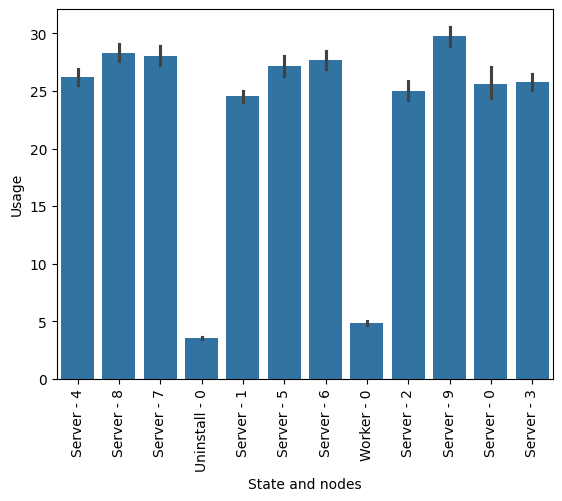

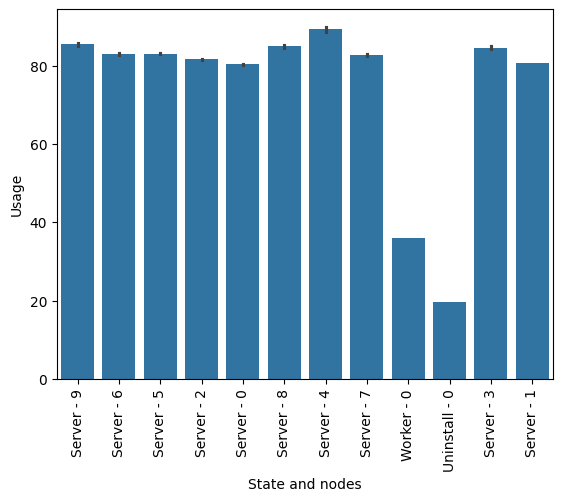

In [50]:
df_cpu_usage = pd.read_csv(exp_dir + "/cpu_usage.csv")
df_ram_usage = pd.read_csv(exp_dir + "/ram_usage.csv")

df_cpu_usage["State and nodes"] = df_cpu_usage["Device Role"].apply(lambda x: x.capitalize() + " - ") + df_cpu_usage["Number of nodes"].apply(lambda x: str(x))
df_ram_usage["State and nodes"] = df_ram_usage["Device Role"].apply(lambda x: x.capitalize() + " - ") + df_ram_usage["Number of nodes"].apply(lambda x: str(x))

plt.figure(figure=(10, 6))
sns.barplot(data=df_cpu_usage, x = "State and nodes", y="Usage")
plt.xticks(rotation=90)
plt.show()

plt.figure(figure=(10, 6))
sns.barplot(data=df_ram_usage, x = "State and nodes", y="Usage")
plt.xticks(rotation=90)
plt.show()


## Experiment 2: Fairphone: Number of requets per second with CPU and RAM usage

In [14]:
# Experiment setup
experiment_name = "K3S cluster request per second"
timestamp = timestamp=datetime.datetime.now() # Current timestamp

n_agents = 13

ssh_server = ["pptc@192.168.88.17"]
server_type = ["Server"]

ssh_agents = ["pptc@192.168.88." + str(i) for i in range(3, 3+n_agents)]
agents_type = ["Agent"] * n_agents

number_of_nodes = range(2, 2 + n_agents)
mediums = ["Ethernet", "WiFi 5.0GHz 20-40-80MHz", "WiFi 2.4GHz 20-40MHz"]
iterations = 10
count_for_usage_script = 120

wrk_threads = 8
wrk_connections_by_device = 10
wrk_duration = "20s"
wrk_lua_script = "./assets/generate_request_script.lua"
cluster_port = 18080

df = pd.DataFrame()
df["SSH infos"] = [ssh_server + ssh_agents[:i-1] for i in number_of_nodes]
df["Node types"] = [server_type + agents_type[:i-1] for i in number_of_nodes]
df["Cluster IP"] = [ssh_server[0].split('@')[1].strip()] * len(number_of_nodes)
df["Number of nodes"] = number_of_nodes
display(df)



,SSH infos,Node types,Cluster IP,Number of nodes
0,"[pptc@192.168.88.17, pptc@192.168.88.3]","[Server, Agent]",192.168.88.17,2
1,"[pptc@192.168.88.17, pptc@192.168.88.3, pptc@1...","[Server, Agent, Agent]",192.168.88.17,3
2,"[pptc@192.168.88.17, pptc@192.168.88.3, pptc@1...","[Server, Agent, Agent, Agent]",192.168.88.17,4
3,"[pptc@192.168.88.17, pptc@192.168.88.3, pptc@1...","[Server, Agent, Agent, Agent, Agent]",192.168.88.17,5
4,"[pptc@192.168.88.17, pptc@192.168.88.3, pptc@1...","[Server, Agent, Agent, Agent, Agent, Agent]",192.168.88.17,6
5,"[pptc@192.168.88.17, pptc@192.168.88.3, pptc@1...","[Server, Agent, Agent, Agent, Agent, Agent, Ag...",192.168.88.17,7
6,"[pptc@192.168.88.17, pptc@192.168.88.3, pptc@1...","[Server, Agent, Agent, Agent, Agent, Agent, Ag...",192.168.88.17,8
7,"[pptc@192.168.88.17, pptc@192.168.88.3, pptc@1...","[Server, Agent, Agent, Agent, Agent, Agent, Ag...",192.168.88.17,9
8,"[pptc@192.168.88.17, pptc@192.168.88.3, pptc@1...","[Server, Agent, Agent, Agent, Agent, Agent, Ag...",192.168.88.17,10
9,"[pptc@192.168.88.17, pptc@192.168.88.3, pptc@1...","[Server, Agent, Agent, Agent, Agent, Agent, Ag...",192.168.88.17,11


In [5]:
def are_pods_ready():
    command = ssh_with_args + " " + ssh_server[0] + " \"kubectl get pods\" | awk '{print $3}' "
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    result = [x.strip() for x in result.stdout.split('\n') if x.strip()]
    
    for x in result:
        if x != "STATUS" and x != "Running": return False
    return True


In [12]:
# Experiment path
exp_folder_name = experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
curr_exp_dir = global_res_dir + "/" + exp_folder_name

# Remote path
remote_exp_results_dir = "~/" + exp_folder_name + "/results"
remote_exp_cpu_usage_dir = remote_exp_results_dir + "/cpu_usage"
remote_exp_ram_usage_dir = remote_exp_results_dir + "/ram_usage"
remote_exp_network_usage_dir = remote_exp_results_dir + "/network_usage"
remote_exp_scripts_dir = "~/" + exp_folder_name + "/scripts"

for med in mediums:
    # Results paths by mediums
    curr_exp_med_dir = curr_exp_dir + "/" + med.replace(' ', '_')
    curr_exp_med_raw_dir = curr_exp_med_dir + "/raw_results"
    curr_exp_med_res_dir = curr_exp_med_dir + "/results"

    # Get interface
    dev_interface = "eth0" if med == "Ethernet" else "wlan0"

    # Create results dir
    path = Path(curr_exp_dir)
    path.mkdir(parents=True, exist_ok=True)
    path = Path(curr_exp_med_dir)
    path.mkdir(parents=True, exist_ok=True)
    path = Path(curr_exp_med_raw_dir)
    path.mkdir(parents=True, exist_ok=True)
    path = Path(curr_exp_med_res_dir)
    path.mkdir(parents=True, exist_ok=True)

    for i in range(df.shape[0]):
        ssh_infos = df.loc[i, "SSH infos"]
        node_types = df.loc[i, "Node types"]
        cluster_ip = df.loc[i, "Cluster IP"]
        n_nodes = df.loc[i, "Number of nodes"]

        print(f"Prepare next config:\n\tMedium: {med}\n\tNumber of nodes: {n_nodes}\n\tSSH infos: {ssh_infos}\n\tDevice types: {node_types}\n\t\n")
        time.sleep(2)
        v = input("Press ENTER to run the benchmark")
        print(f"Value : {v}")
        if v == "s": # stop
            break
        print("Run benchmark...")

        curr_exp_med_raw_file = curr_exp_med_raw_dir + f"/results_request_per_second_{n_nodes}.txt"

        # Remote paths
        cpu_usage_remote_file = remote_exp_cpu_usage_dir + "/results_cpu_usage_" + med.replace(' ', '_') + "_" + str(n_nodes) + "_"
        ram_usage_remote_file = remote_exp_ram_usage_dir + "/results_ram_usage_" + med.replace(' ', '_') + "_" + str(n_nodes) + "_"
        network_usage_remote_file = remote_exp_network_usage_dir + "/results_network_usage_" + med.replace(' ', '_') + "_" + str(n_nodes) + "_"

        for j in range(len(ssh_infos)):
            ssh_info = ssh_infos[j]
            # Copy scripts on remote device
            !{ssh_with_args} {ssh_info} "mkdir -p ~/{exp_folder_name}"
            !{scp_with_args} -r scripts/ {ssh_info}:~/{exp_folder_name}
            
            # Create remote workspace
            !{ssh_with_args} {ssh_info} "mkdir -p {remote_exp_cpu_usage_dir}; mkdir -p {remote_exp_ram_usage_dir}; mkdir -p {remote_exp_network_usage_dir}"

            # Write config on remote for cpu and ram usage
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iterations}\n# NUMBER_NODES={n_nodes}\n# NODE_TYPE={node_types[j]}\n# MEDIUM={med}\n# COUNT={count_for_usage_script}\n\" > {cpu_usage_remote_file + ssh_info}.txt"
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iterations}\n# NUMBER_NODES={n_nodes}\n# NODE_TYPE={node_types[j]}\n# MEDIUM={med}\n# COUNT={count_for_usage_script}\n\" > {ram_usage_remote_file + ssh_info}.txt"
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iterations}\n# NUMBER_NODES={n_nodes}\n# NODE_TYPE={node_types[j]}\n# MEDIUM={med}\n# COUNT={count_for_usage_script}\n# INTERFACE={dev_interface}\n\" > {network_usage_remote_file + ssh_info}.txt"

        
        # Local for execution time
        with open(curr_exp_med_raw_file, "w") as raw:
            raw.write(f"# SSH_INFO={ssh_info}\n")
            raw.write(f"# ITERATIONS={iterations}\n")
            raw.write(f"# NUMBER_NODES={n_nodes}\n")
            raw.write(f"# NODE_TYPE={node_types}\n")
            raw.write(f"# MEDIUM={med}\n")
            raw.write(f"# WRK_THREADS={wrk_threads}\n")
            raw.write(f"# WRK_CONNECTION={wrk_connections_by_device * (n_nodes - 1)}\n")
            raw.write(f"# WRK_DURATION={wrk_duration}\n")

        for iter in range(iterations):
            print(f"Iteration {iter}")
            with open(curr_exp_med_raw_file, "a") as raw:
                raw.write(f"\n# ITERATION {iter}\n")

            cpu_usage_processes = []
            ram_usage_processes = []
            network_usage_processes = []

            for ssh_info in ssh_infos:
                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {iter}\n\" >> {cpu_usage_remote_file + ssh_info}.txt"
                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {iter}\n\" >> {ram_usage_remote_file + ssh_info}.txt"
                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {iter}\n\" >> {network_usage_remote_file + ssh_info}.txt"
            
                cpu_usage_processes.append(subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/cpu_usage_script.sh {count_for_usage_script} {cpu_usage_remote_file + ssh_info}.txt 0"', shell=True))
                ram_usage_processes.append(subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/ram_usage_script.sh {count_for_usage_script} {ram_usage_remote_file + ssh_info}.txt 0"', shell=True))
                network_usage_processes.append(subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/network_usage_script.sh {count_for_usage_script} {network_usage_remote_file + ssh_info}.txt {dev_interface} 0"', shell=True))

            time.sleep(5) # To have more usage measures

            print("Perform measure")
            start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
            command = f"wrk -t {wrk_threads} -c {wrk_connections_by_device * (n_nodes - 1)} -d {wrk_duration} -s {wrk_lua_script} http://{cluster_ip}:{cluster_port}/label_image"
            result = subprocess.run(command, shell=True, capture_output=True, text=True)
            with open(curr_exp_med_raw_file, "a") as raw:
                raw.write(result.stdout)
            stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started

            time.sleep(5)  # To have more usage measures

            print("Kill CPU and RAM usage scripts") 
            for j in range(len(ssh_infos)):
                cpu_usage_processes[j].kill()
                ram_usage_processes[j].kill()
                network_usage_processes[j].kill()

                ssh_info = ssh_infos[j]
                !{ssh_with_args} {ssh_info} 'kill $(pidof cpu_usage_script.sh)'
                !{ssh_with_args} {ssh_info} 'kill $(pidof ram_usage_script.sh)'
                !{ssh_with_args} {ssh_info} 'kill $(pidof network_usage_script.sh)'

                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {cpu_usage_remote_file + ssh_info}.txt; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {cpu_usage_remote_file + ssh_info}.txt"
                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {ram_usage_remote_file + ssh_info}.txt; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {ram_usage_remote_file + ssh_info}.txt"
                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {network_usage_remote_file + ssh_info}.txt; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {network_usage_remote_file + ssh_info}.txt"

            # Restart all pods to remove old requests
            !{ssh_with_args} {ssh_server[0]} "kubectl rollout restart deployment k3s-tflite-app-deployment"
            while not are_pods_ready():
                time.sleep(1)

        # Retrieve usage results and remove remote experiment directory
        for ssh_info in ssh_infos:
            print("Retrieve usage results and remove remote workspace")
            !{scp_with_args} -r {ssh_info}:{remote_exp_cpu_usage_dir} {curr_exp_med_raw_dir}
            !{scp_with_args} -r {ssh_info}:{remote_exp_ram_usage_dir} {curr_exp_med_raw_dir}
            !{scp_with_args} -r {ssh_info}:{remote_exp_network_usage_dir} {curr_exp_med_raw_dir}

            !{ssh_with_args} {ssh_info} "rm -rf ~/{exp_folder_name}"


Value : 
Run benchmark...
network_usage_script.sh                       100% 1281   538.5KB/s   00:00    
cpu_usage_script.sh                           100% 1189   721.2KB/s   00:00    
ram_usage_script.sh                           100% 1253   490.9KB/s   00:00    
network_usage_script.sh                       100% 1281   460.7KB/s   00:00    
cpu_usage_script.sh                           100% 1189   655.2KB/s   00:00    
ram_usage_script.sh                           100% 1253   608.8KB/s   00:00    
network_usage_script.sh                       100% 1281   615.7KB/s   00:00    
cpu_usage_script.sh                           100% 1189   721.0KB/s   00:00    
ram_usage_script.sh                           100% 1253   712.7KB/s   00:00    
network_usage_script.sh                       100% 1281   622.1KB/s   00:00    
cpu_usage_script.sh                           100% 1189   632.9KB/s   00:00    
ram_usage_script.sh                           100% 1253   611.9KB/s   00:00    
network_usage_

Perform measure
Kill CPU and RAM usage scripts
deployment.apps/k3s-tflite-app-deployment restarted
Iteration 1


Perform measure
Kill CPU and RAM usage scripts
deployment.apps/k3s-tflite-app-deployment restarted
Iteration 2


Perform measure
Kill CPU and RAM usage scripts
deployment.apps/k3s-tflite-app-deployment restarted
Iteration 3


Perform measure
Kill CPU and RAM usage scripts
deployment.apps/k3s-tflite-app-deployment restarted
Iteration 4


Perform measure
Kill CPU and RAM usage scripts
deployment.apps/k3s-tflite-app-deployment restarted
Iteration 5


Perform measure
Kill CPU and RAM usage scripts
deployment.apps/k3s-tflite-app-deployment restarted
Iteration 6


Perform measure
Kill CPU and RAM usage scripts
deployment.apps/k3s-tflite-app-deployment restarted
Iteration 7


Perform measure
Kill CPU and RAM usage scripts
deployment.apps/k3s-tflite-app-deployment restarted
Iteration 8


Perform measure
Kill CPU and RAM usage scripts
deployment.apps/k3s-tflite-app-deployment restarted
Iteration 9


Perform measure
Kill CPU and RAM usage scripts
deployment.apps/k3s-tflite-app-deployment restarted
Retrieve usage results and remove remote workspace
results_cpu_usage_WiFi_2.4GHz_20-40MHz_9_pptc 100%   21KB   2.6MB/s   00:00    
results_ram_usage_WiFi_2.4GHz_20-40MHz_9_pptc 100%   21KB   3.5MB/s   00:00    
results_network_usage_WiFi_2.4GHz_20-40MHz_9_ 100%   14KB   2.2MB/s   00:00    
Retrieve usage results and remove remote workspace
results_cpu_usage_WiFi_2.4GHz_20-40MHz_9_pptc 100%   21KB   2.6MB/s   00:00    
results_ram_usage_WiFi_2.4GHz_20-40MHz_9_pptc 100%   22KB   3.1MB/s   00:00    
results_network_usage_WiFi_2.4GHz_20-40MHz_9_ 100%   14KB   3.0MB/s   00:00    
Retrieve usage results and remove remote workspace
results_cpu_usage_WiFi_2.4GHz_20-40MHz_9_pptc 100%   21KB   3.6MB/s   00:00    
results_ram_usage_WiFi_2.4GHz_20-40MHz_9_pptc 100%   23KB   3.9MB/s   00:00    
results_network_usage_WiFi_2.4GHz_20-40MHz_9_ 100%   14KB   3.2MB/s   00:00    
Retrieve usage results and r

### Process results

In [35]:
def process_request_per_second_raw_results_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    n_nodes=0
    medium=""
    wrk_threads=0
    wrk_duration=0
    wrk_connections=0


    request_s = []
    iterations = []

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# NUMBER_NODES="):
                n_nodes = int(line.split('=')[1].strip())
            elif line.startswith("# WRK_THREADS="):
                wrk_threads = line.split('=')[1].strip()
            elif line.startswith("# WRK_DURATION="):
                wrk_duration = line.split('=')[1].strip()
            elif line.startswith("# WRK_CONNECTION="):
                wrk_connections = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                iterations.append(int(line.split(' ')[2].strip()))
            elif line.startswith("Requests/sec:"):
                request_s.append(float(line.split(':')[1].strip()))


    df["Iteration"] = iterations
    df["Request/s"] = request_s
    df["Medium"] = [medium] * df.shape[0]
    df["Number of Nodes"] = [n_nodes] * df.shape[0]
    df["WRK Threads"] = [wrk_threads] * df.shape[0]
    df["WRK Duration"] = [wrk_duration] * df.shape[0]
    df["WRK Connections"] = [wrk_connections] * df.shape[0]

    return df

def process_cpu_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    ssh_info=""
    node_type=""
    n_nodes=0

    timestamp_values = []
    user_values = []
    nice_values = []
    system_values = []
    idle_values = []
    iowait_values = []
    irq_values = []
    softirq_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# SSH_INFO="):
                ssh_info = line.split('=')[1].strip()
            elif line.startswith("# NODE_TYPE="):
                node_type = line.split('=')[1].strip()
            elif line.startswith("# NUMBER_NODES="):
                n_nodes = int(line.split('=')[1].strip())
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, user_v, nice_v, system_v, idle_v, iowait_v, irq_v, softirq_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                user_values.append(float(user_v.strip()))
                nice_values.append(float(nice_v.strip()))
                system_values.append(float(system_v.strip()))
                idle_values.append(float(idle_v.strip()))
                iowait_values.append(float(iowait_v.strip()))
                irq_values.append(float(irq_v.strip()))
                softirq_values.append(float(softirq_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["SSH Info"] = [ssh_info] * df.shape[0]
    df["Node Type"] = [node_type] * df.shape[0]
    df["Number of Nodes"] = [n_nodes] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["User"] = user_values
    df["Nice"] = nice_values
    df["System"] = system_values
    df["Idle"] = idle_values
    df["IOwait"] = iowait_values
    df["IRQ"] = irq_values
    df["SoftIRQ"] = softirq_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]


    # Compute CPU usage and Timestamp from 0
    df['Total'] = df[["User", "Nice", "System", "Idle", "IOwait", "IRQ", "SoftIRQ"]].sum(axis=1)
    
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])

        group['Last Idle'] = group['Idle'].shift(1).fillna(0)
        group['Last Total'] = group['Total'].shift(1).fillna(0)
        group['Idle Delta'] = group['Idle'] - group['Last Idle']
        group['Total Delta'] = group['Total'] - group['Last Total']
        group['Usage'] = 100.0 * (1.0 - (group['Idle Delta'] / group['Total Delta']))

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df.drop(["Total"], axis="columns")


def process_ram_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    ssh_info=""
    node_type=""
    n_nodes=0

    timestamp_values = []
    memtotal_values = []
    memfree_values = []
    memavailable_values = []
    cache_values = []
    buffer_values = []
    swaptotal_values = []
    swapfree_values = []
    swapcached_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# SSH_INFO="):
                ssh_info = line.split('=')[1].strip()
            elif line.startswith("# NODE_TYPE="):
                node_type = line.split('=')[1].strip()
            elif line.startswith("# NUMBER_NODES="):
                n_nodes = int(line.split('=')[1].strip())
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, memtotal_v, memfree_v, memavailable_v, cache_v, buffer_v, swaptotal_v, swapfree_v, swapcached_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                memtotal_values.append(float(memtotal_v.strip()))
                memfree_values.append(float(memfree_v.strip()))
                memavailable_values.append(float(memavailable_v.strip()))
                cache_values.append(float(cache_v.strip()))
                buffer_values.append(float(buffer_v.strip()))
                swaptotal_values.append(float(swaptotal_v.strip()))
                swapfree_values.append(float(swapfree_v.strip()))
                swapcached_values.append(float(swapcached_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["SSH Info"] = [ssh_info] * df.shape[0]
    df["Node Type"] = [node_type] * df.shape[0]
    df["Number of Nodes"] = [n_nodes] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["Total Memory"] = memtotal_values
    df["Free Memory"] = memfree_values
    df["Available Memory"] = memavailable_values
    df["Cache"] = cache_values
    df["Buffer"] = buffer_values
    df["Total Swap"] = swaptotal_values
    df["Free Swap"] = swapfree_values
    df["Cached Swap"] = swapcached_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]


    # Compute RAM usage and Timestamp from 0
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])
        group["Usage"] = (1 - (group["Free Memory"]/group["Total Memory"])) * 100.0

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df


def process_network_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    ssh_info=""
    node_type=""
    interface=""
    n_nodes=0

    timestamp_values = []
    reiceived_bytes = []
    sent_bytes = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# SSH_INFO="):
                ssh_info = line.split('=')[1].strip()
            elif line.startswith("# NODE_TYPE="):
                node_type = line.split('=')[1].strip()
            elif line.startswith("# NUMBER_NODES="):
                n_nodes = int(line.split('=')[1].strip())
            elif line.startswith("# INTERFACE="):
                interface = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, received_byte, sent_byte = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                reiceived_bytes.append(float(received_byte.strip()))
                sent_bytes.append(float(sent_byte.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["SSH Info"] = [ssh_info] * df.shape[0]
    df["Node Type"] = [node_type] * df.shape[0]
    df["Number of Nodes"] = [n_nodes] * df.shape[0]
    df["Interface"] = [interface] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["Total Received Bytes"] = reiceived_bytes
    df["Total Sent Bytes"] = sent_bytes
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]


    # Compute Network usage and Timestamp from 0
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])

        group['Last Total Received Bytes'] = group['Total Received Bytes'].shift(1).fillna(group.loc[0, "Total Received Bytes"])
        group['Last Total Sent Bytes'] = group['Total Sent Bytes'].shift(1).fillna(group.loc[0, "Total Sent Bytes"])
        group["Received Mbits/s"] = (group['Total Received Bytes'] - group['Last Total Received Bytes']) * 8 / 1000000
        group["Sent Mbits/s"] = (group['Total Sent Bytes'] - group['Last Total Sent Bytes']) * 8 / 1000000

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Received Mbits/s"] = df_usage["Received Mbits/s"]
    df["Sent Mbits/s"] = df_usage["Sent Mbits/s"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df



In [36]:
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Fairphone"

df_req_per_sec = []
df_cpu_usages = []
df_ram_usages= []
df_network_usages= []

for med in mediums:
    exp_med_dir = exp_dir + "/" + med.replace(' ', '_')
    exp_med_raw_dir = exp_med_dir + "/raw_results"
    exp_cpu_med_raw_dir = exp_med_raw_dir + "/cpu_usage"
    exp_ram_med_raw_dir = exp_med_raw_dir + "/ram_usage"
    exp_network_med_raw_dir = exp_med_raw_dir + "/network_usage"
    exp_med_res_dir = exp_med_dir + "/results"

    path = Path(exp_med_res_dir)
    path.mkdir(parents=True, exist_ok=True)

    # Execution time by part
    df_req_per_sec_med = []
    for file in os.listdir(exp_med_raw_dir):
        file = exp_med_raw_dir + "/" + file
        if os.path.isfile(file):
            df_req_per_sec_med.append(process_request_per_second_raw_results_to_dataframe(file))
    df_req_per_sec_med = pd.concat(df_req_per_sec_med, ignore_index=True)
    df_req_per_sec.append(df_req_per_sec_med)
    df_req_per_sec_med.to_csv(exp_med_res_dir + "/request_per_sec_" + med.replace(' ', '_') + ".csv", index=False)

    # CPU usage
    df_cpu_usages_med = []
    for file in os.listdir(exp_cpu_med_raw_dir):
        df_cpu_usages_med.append(process_cpu_usage_to_dataframe(exp_cpu_med_raw_dir + "/" + file))
    df_cpu_usages_med = pd.concat(df_cpu_usages_med, ignore_index=True)
    df_cpu_usages.append(df_cpu_usages_med)
    df_cpu_usages_med.to_csv(exp_med_res_dir + "/cpu_usage_" + med.replace(' ', '_') + ".csv", index=False)


    # RAM usage
    df_ram_usages_med = []
    for file in os.listdir(exp_ram_med_raw_dir):
        df_ram_usages_med.append(process_ram_usage_to_dataframe(exp_ram_med_raw_dir + "/" + file))
    df_ram_usages_med = pd.concat(df_ram_usages_med, ignore_index=True)
    df_ram_usages.append(df_ram_usages_med)
    df_cpu_usages_med.to_csv(exp_med_res_dir + "/ram_usage_" + med.replace(' ', '_') + ".csv", index=False)

    # NETWORK usage
    df_network_usages_med = []
    for file in os.listdir(exp_network_med_raw_dir):
        df_network_usages_med.append(process_network_usage_to_dataframe(exp_network_med_raw_dir + "/" + file))
    df_network_usages_med = pd.concat(df_network_usages_med, ignore_index=True)
    df_network_usages.append(df_network_usages_med)
    df_network_usages_med.to_csv(exp_med_res_dir + "/network_usage_" + med.replace(' ', '_') + ".csv", index=False)

# Execution time by part
df_req_per_sec = pd.concat(df_req_per_sec, ignore_index=True)
df_req_per_sec.to_csv(exp_dir + "/request_per_sec.csv", index=False)

# CPU usage
df_cpu_usages = pd.concat(df_cpu_usages, ignore_index=True)
df_cpu_usages.to_csv(exp_dir + "/cpu_usage.csv", index=False)

# RAM usage
df_ram_usages = pd.concat(df_ram_usages, ignore_index=True)
df_ram_usages.to_csv(exp_dir + "/ram_usage.csv", index=False)

# Network usage
df_network_usages = pd.concat(df_network_usages, ignore_index=True)
df_network_usages.to_csv(exp_dir + "/network_usage.csv", index=False)

# display(df_execution_time_by_part)
# display(df_cpu_usages)
# display(df_ram_usages)

### Make Graphs

In [15]:
# Global variables
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Fairphone"

graphs_dir = exp_dir + "/graphs"
graphs_req_per_sec_dir = graphs_dir + "/request_per_sec"
graphs_cpu_usage_dir = graphs_dir + "/cpu_usage"
graphs_ram_usage_dir = graphs_dir + "/ram_usage"
graphs_network_usage_dir = graphs_dir + "/network_usage"

path = Path(graphs_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_req_per_sec_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_cpu_usage_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_ram_usage_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_network_usage_dir)
path.mkdir(parents=True, exist_ok=True)

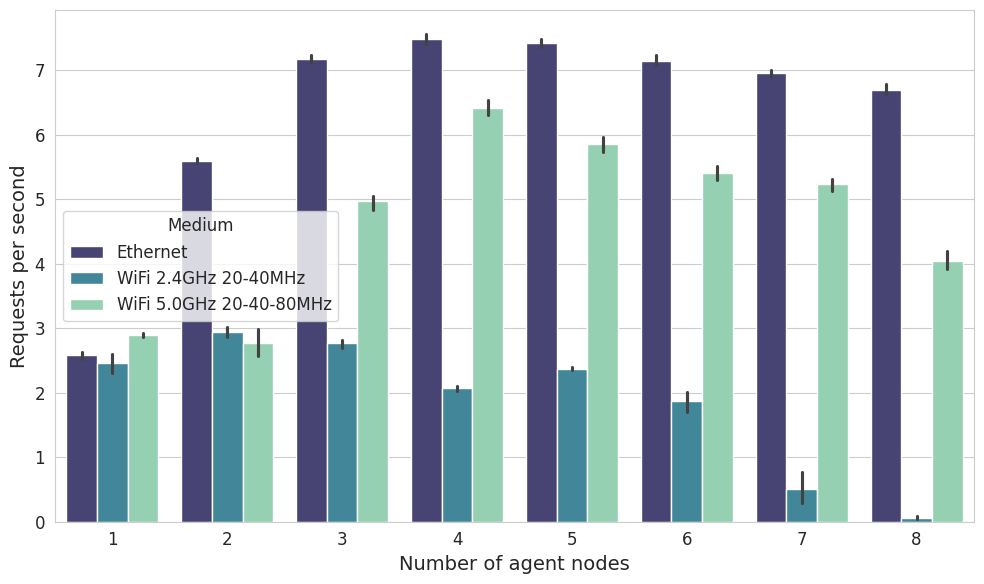

In [16]:
df_req_per_sec = pd.read_csv(exp_dir + "/request_per_sec.csv")
df_req_per_sec["Number of Agents"] = df_req_per_sec["Number of Nodes"] - 1


mediums = ["Ethernet", "WiFi 2.4GHz 20-40MHz", "WiFi 5.0GHz 20-40-80MHz"]

# for med in mediums:
#         df_exec_time_imp = df_req_per_sec[df_req_per_sec["Medium"] == med]
#         # Barplot comparison
#         plt.figure(figsize=(10, 6))
#         sns.set_style("whitegrid")
#         sns.barplot(data=df_exec_time_imp, x='Number of Agents', y='Request/s')

#         plt.ylim(bottom=0)
#         plt.tight_layout()
    
#         plt.savefig(graphs_req_per_sec_dir + "/barplot_Fairphone_" + experiment_name.replace(' ', '_') + "_" + med.replace(' ', '_') + ".pdf")
#         plt.show()


# Barplot comparison
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(data=df_req_per_sec, x='Number of Agents', y='Request/s',  hue="Medium", hue_order=mediums, palette=sns.color_palette('mako')[1::2])

plt.xlabel("Number of agent nodes")
plt.ylabel("Requests per second")
plt.ylim(bottom=0)
plt.tight_layout()

plt.savefig(graphs_req_per_sec_dir + "/barplot_Fairphone_req_per_sec" + experiment_name.replace(' ', '_') + ".pdf")
plt.show()

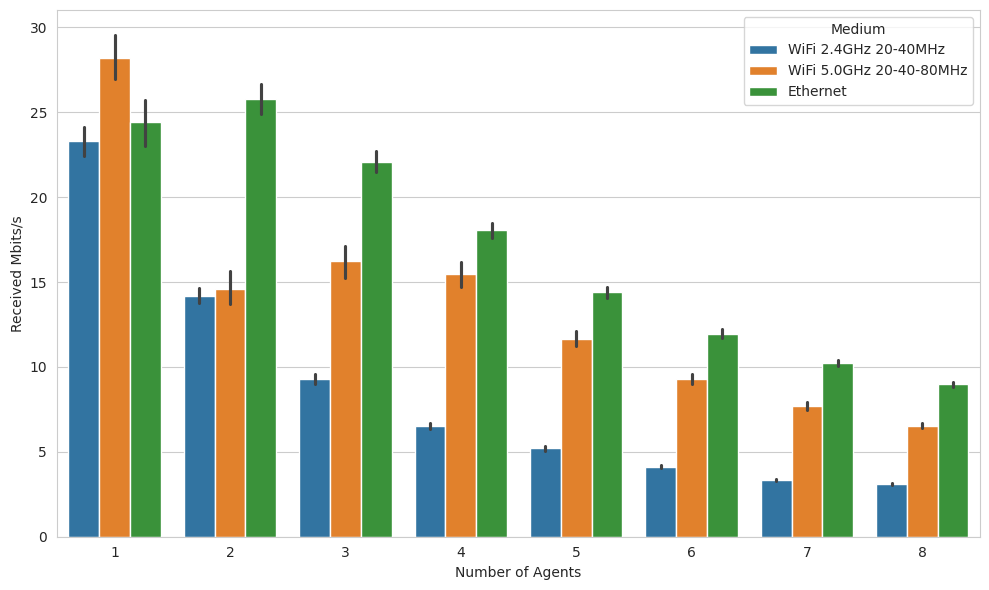

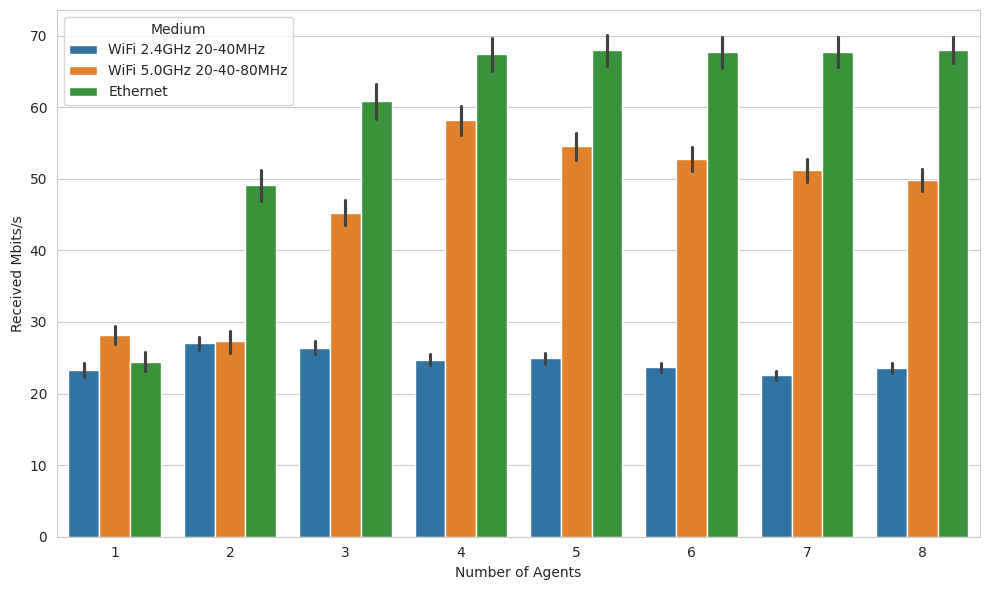

(4765, 18)


In [20]:
df_network_usage = pd.read_csv(exp_dir + "/network_usage.csv")
df_network_usage["Number of Agents"] = df_network_usage["Number of Nodes"] - 1

df_network_usage = df_network_usage[df_network_usage["Has Workload"] == True]
df_network_usage_agent = df_network_usage[df_network_usage["Node Type"] == "Agent"]
df_network_usage_server = df_network_usage[df_network_usage["Node Type"] == "Server"]

mediums = ["WiFi 2.4GHz 20-40MHz", "WiFi 5.0GHz 20-40-80MHz", "Ethernet"]


plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(data=df_network_usage_agent, x='Number of Agents', y='Received Mbits/s',  hue="Medium", hue_order=mediums)

plt.ylim(bottom=0)
plt.tight_layout()

plt.savefig(graphs_network_usage_dir + "/barplot_Fairphone_received_mbits_s_per_device" + experiment_name.replace(' ', '_') + ".pdf")
plt.show()


# Mbits total = sum of received mbit per timestmap

iter_group = df_network_usage_agent.groupby(['Iteration', 'Timestamp', 'Number of Agents', "Medium"])['Received Mbits/s'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(data=iter_group, x='Number of Agents', y='Received Mbits/s',  hue="Medium", hue_order=mediums)

plt.ylim(bottom=0)
plt.tight_layout()

# plt.savefig(graphs_network_usage_dir + "/barplot_Fairphone_received_mbits_s_per_device" + experiment_name.replace(' ', '_') + ".pdf")
plt.show()



In [ ]:
df_network_usage = pd.read_csv(exp_dir + "/network_usage.csv")
df_network_usage["Number of Agents"] = df_network_usage["Number of Nodes"] - 1

df_network_usage = df_network_usage[df_network_usage["Has Workload"] == True]
df_network_usage_agent = df_network_usage[df_network_usage["Node Type"] == "Agent"]
df_network_usage_server = df_network_usage[df_network_usage["Node Type"] == "Server"]

mediums = ["WiFi 2.4GHz 20-40MHz", "WiFi 5.0GHz 20-40-80MHz", "Ethernet"]


In [ ]:
# Mbits total = sum of received mbit per timestmap

iter_group = df_network_usage_agent.groupby(['Iteration', 'Timestamp', 'Number of Agents', "Medium"])['Received Mbits/s'].sum().reset_index()
iter_group = iter_group.set_index("Timestamp")
iter_group_serv = df_network_usage_server.groupby(['Iteration', 'Timestamp', 'Number of Agents', "Medium"])['Sent Mbits/s'].sum().reset_index()
iter_group_serv = iter_group_serv.set_index("Timestamp")
iter_group_serv = iter_group_serv['Sent Mbits/s']

iter_group = iter_group.join(iter_group_serv, how='inner')

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(data=iter_group, x='Number of Agents', y='Received Mbits/s',  hue="Medium", hue_order=mediums)

plt.ylim(bottom=0)
plt.tight_layout()

# plt.savefig(graphs_network_usage_dir + "/barplot_Fairphone_received_mbits_s_per_device" + experiment_name.replace(' ', '_') + ".pdf")
plt.show()

print(df_network_usage_server.shape)


## Experiment 2bis: Raspberry: Number of requets per second with CPU and RAM usage

In [17]:
# Experiment setup
experiment_name = "K3S cluster request per second"
timestamp = timestamp=datetime.datetime.now() # Current timestamp

n_agents = 13

ssh_server = ["pi@192.168.88.101"]
server_type = ["Server"]
server_distrib = ["Ubuntu"]

ssh_agents = ["pptc@192.168.88." + str(i) for i in range(3, 3+n_agents)]
agents_type = ["Agent"] * n_agents
agents_distrib = ["Alpine"] * n_agents

number_of_nodes = range(2, 2 + n_agents)
mediums = ["Ethernet", "WiFi 5.0GHz 20-40-80MHz", "WiFi 2.4GHz 20-40MHz"]
iterations = 10
count_for_usage_script = 120

wrk_threads = 8
wrk_connections_by_device = 10
wrk_duration = "20s"
wrk_lua_script = "./assets/generate_request_script.lua"
cluster_port = 31000

df = pd.DataFrame()
df["SSH infos"] = [ssh_server + ssh_agents[:i-1] for i in number_of_nodes]
df["Node types"] = [server_type + agents_type[:i-1] for i in number_of_nodes]
df["Cluster IP"] = [ssh_server[0].split('@')[1].strip()] * len(number_of_nodes)
df["Distributions"] = [server_distrib + agents_distrib[:i-1] for i in number_of_nodes]
df["Number of nodes"] = number_of_nodes
display(df)



,SSH infos,Node types,Cluster IP,Distributions,Number of nodes
0,"[pi@192.168.88.101, pptc@192.168.88.3]","[Server, Agent]",192.168.88.101,"[Ubuntu, Alpine]",2
1,"[pi@192.168.88.101, pptc@192.168.88.3, pptc@19...","[Server, Agent, Agent]",192.168.88.101,"[Ubuntu, Alpine, Alpine]",3
2,"[pi@192.168.88.101, pptc@192.168.88.3, pptc@19...","[Server, Agent, Agent, Agent]",192.168.88.101,"[Ubuntu, Alpine, Alpine, Alpine]",4
3,"[pi@192.168.88.101, pptc@192.168.88.3, pptc@19...","[Server, Agent, Agent, Agent, Agent]",192.168.88.101,"[Ubuntu, Alpine, Alpine, Alpine, Alpine]",5
4,"[pi@192.168.88.101, pptc@192.168.88.3, pptc@19...","[Server, Agent, Agent, Agent, Agent, Agent]",192.168.88.101,"[Ubuntu, Alpine, Alpine, Alpine, Alpine, Alpine]",6
5,"[pi@192.168.88.101, pptc@192.168.88.3, pptc@19...","[Server, Agent, Agent, Agent, Agent, Agent, Ag...",192.168.88.101,"[Ubuntu, Alpine, Alpine, Alpine, Alpine, Alpin...",7
6,"[pi@192.168.88.101, pptc@192.168.88.3, pptc@19...","[Server, Agent, Agent, Agent, Agent, Agent, Ag...",192.168.88.101,"[Ubuntu, Alpine, Alpine, Alpine, Alpine, Alpin...",8
7,"[pi@192.168.88.101, pptc@192.168.88.3, pptc@19...","[Server, Agent, Agent, Agent, Agent, Agent, Ag...",192.168.88.101,"[Ubuntu, Alpine, Alpine, Alpine, Alpine, Alpin...",9
8,"[pi@192.168.88.101, pptc@192.168.88.3, pptc@19...","[Server, Agent, Agent, Agent, Agent, Agent, Ag...",192.168.88.101,"[Ubuntu, Alpine, Alpine, Alpine, Alpine, Alpin...",10
9,"[pi@192.168.88.101, pptc@192.168.88.3, pptc@19...","[Server, Agent, Agent, Agent, Agent, Agent, Ag...",192.168.88.101,"[Ubuntu, Alpine, Alpine, Alpine, Alpine, Alpin...",11


In [18]:
def are_pods_ready():
    command = ssh_with_args + " " + ssh_server[0] + " \"kubectl get pods\" | awk '{print $3}' "
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    result = [x.strip() for x in result.stdout.split('\n') if x.strip()]
    
    for x in result:
        if x != "STATUS" and x != "Running": return False
    return True


In [19]:
# Experiment path
exp_folder_name = experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
curr_exp_dir = global_res_dir + "/" + exp_folder_name

# Remote path
remote_exp_results_dir = "~/" + exp_folder_name + "/results"
remote_exp_cpu_usage_dir = remote_exp_results_dir + "/cpu_usage"
remote_exp_ram_usage_dir = remote_exp_results_dir + "/ram_usage"
remote_exp_network_usage_dir = remote_exp_results_dir + "/network_usage"
remote_exp_scripts_dir = "~/" + exp_folder_name + "/scripts"

for med in mediums:
    # Results paths by mediums
    curr_exp_med_dir = curr_exp_dir + "/" + med.replace(' ', '_')
    curr_exp_med_raw_dir = curr_exp_med_dir + "/raw_results"
    curr_exp_med_res_dir = curr_exp_med_dir + "/results"

    # Get interface
    dev_interface = "eth0" if med == "Ethernet" else "wlan0"

    # Create results dir
    path = Path(curr_exp_dir)
    path.mkdir(parents=True, exist_ok=True)
    path = Path(curr_exp_med_dir)
    path.mkdir(parents=True, exist_ok=True)
    path = Path(curr_exp_med_raw_dir)
    path.mkdir(parents=True, exist_ok=True)
    path = Path(curr_exp_med_res_dir)
    path.mkdir(parents=True, exist_ok=True)

    for i in range(df.shape[0]):
        ssh_infos = df.loc[i, "SSH infos"]
        node_types = df.loc[i, "Node types"]
        cluster_ip = df.loc[i, "Cluster IP"]
        n_nodes = df.loc[i, "Number of nodes"]
        distribs = df.loc[i, "Distributions"]

        print(f"Prepare next config:\n\tMedium: {med}\n\tNumber of nodes: {n_nodes}\n\tSSH infos: {ssh_infos}\n\tDevice types: {node_types}\n\t\n")
        time.sleep(2)
        v = input("Press ENTER to run the benchmark")
        print(f"Value : {v}")
        if v == "s": # stop
            break
        print("Run benchmark...")

        curr_exp_med_raw_file = curr_exp_med_raw_dir + f"/results_request_per_second_{n_nodes}.txt"

        # Remote paths
        cpu_usage_remote_file = remote_exp_cpu_usage_dir + "/results_cpu_usage_" + med.replace(' ', '_') + "_" + str(n_nodes) + "_"
        ram_usage_remote_file = remote_exp_ram_usage_dir + "/results_ram_usage_" + med.replace(' ', '_') + "_" + str(n_nodes) + "_"
        network_usage_remote_file = remote_exp_network_usage_dir + "/results_network_usage_" + med.replace(' ', '_') + "_" + str(n_nodes) + "_"

        for j in range(len(ssh_infos)):
            ssh_info = ssh_infos[j]
            distrib = distribs[j]
            # Copy scripts on remote device
            !{ssh_with_args} {ssh_info} "mkdir -p ~/{exp_folder_name}"
            !{scp_with_args} -r scripts/ {ssh_info}:~/{exp_folder_name}
            
            # Create remote workspace
            !{ssh_with_args} {ssh_info} "mkdir -p {remote_exp_cpu_usage_dir}; mkdir -p {remote_exp_ram_usage_dir}; mkdir -p {remote_exp_network_usage_dir}"

            # Write config on remote for cpu and ram usage
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iterations}\n# NUMBER_NODES={n_nodes}\n# NODE_TYPE={node_types[j]}\n# MEDIUM={med}\n# COUNT={count_for_usage_script}\n# DISTRIBUTION={distrib}\n\" > {cpu_usage_remote_file + ssh_info}.txt"
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iterations}\n# NUMBER_NODES={n_nodes}\n# NODE_TYPE={node_types[j]}\n# MEDIUM={med}\n# COUNT={count_for_usage_script}\n# DISTRIBUTION={distrib}\n\" > {ram_usage_remote_file + ssh_info}.txt"
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iterations}\n# NUMBER_NODES={n_nodes}\n# NODE_TYPE={node_types[j]}\n# MEDIUM={med}\n# COUNT={count_for_usage_script}\n# INTERFACE={dev_interface}\n# DISTRIBUTION={distrib}\n\" > {network_usage_remote_file + ssh_info}.txt"

        
        # Local for execution time
        with open(curr_exp_med_raw_file, "w") as raw:
            raw.write(f"# SSH_INFO={ssh_server}\n")
            raw.write(f"# ITERATIONS={iterations}\n")
            raw.write(f"# NUMBER_NODES={n_nodes}\n")
            raw.write(f"# NODE_TYPE={node_types}\n")
            raw.write(f"# MEDIUM={med}\n")
            raw.write(f"# WRK_THREADS={wrk_threads}\n")
            raw.write(f"# WRK_CONNECTION={wrk_connections_by_device * (n_nodes - 1)}\n")
            raw.write(f"# WRK_DURATION={wrk_duration}\n")

        for iter in range(iterations):
            print(f"Iteration {iter}")
            with open(curr_exp_med_raw_file, "a") as raw:
                raw.write(f"\n# ITERATION {iter}\n")

            cpu_usage_processes = []
            ram_usage_processes = []
            network_usage_processes = []

            for k in range(len(ssh_infos)):
                ssh_info = ssh_infos[k]
                distrib = distribs[k]

                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {iter}\n\" >> {cpu_usage_remote_file + ssh_info}.txt"
                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {iter}\n\" >> {ram_usage_remote_file + ssh_info}.txt"
                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {iter}\n\" >> {network_usage_remote_file + ssh_info}.txt"
            
                cpu_usage_processes.append(subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/cpu_usage_script.sh {count_for_usage_script} {cpu_usage_remote_file + ssh_info}.txt 0"', shell=True))
                ram_usage_processes.append(subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/ram_usage_script.sh {count_for_usage_script} {ram_usage_remote_file + ssh_info}.txt 0"', shell=True))
                network_usage_processes.append(subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/network_usage_script.sh {count_for_usage_script} {network_usage_remote_file + ssh_info}.txt {dev_interface} {distrib} 0"', shell=True))

            time.sleep(5) # To have more usage measures

            print("Perform measure")
            start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
            command = f"wrk -t {wrk_threads} -c {wrk_connections_by_device * (n_nodes - 1)} -d {wrk_duration} -s {wrk_lua_script} http://{cluster_ip}:{cluster_port}/label_image"
            result = subprocess.run(command, shell=True, capture_output=True, text=True)
            with open(curr_exp_med_raw_file, "a") as raw:
                raw.write(result.stdout)
            stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started

            time.sleep(5)  # To have more usage measures

            print("Kill CPU and RAM usage scripts") 
            for j in range(len(ssh_infos)):
                cpu_usage_processes[j].kill()
                ram_usage_processes[j].kill()
                network_usage_processes[j].kill()

                ssh_info = ssh_infos[j]
                !{ssh_with_args} {ssh_info} 'kill $(pgrep -f cpu_usage_script.sh)'
                !{ssh_with_args} {ssh_info} 'kill $(pgrep -f ram_usage_script.sh)'
                !{ssh_with_args} {ssh_info} 'kill $(pgrep -f network_usage_script.sh)'

                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {cpu_usage_remote_file + ssh_info}.txt; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {cpu_usage_remote_file + ssh_info}.txt"
                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {ram_usage_remote_file + ssh_info}.txt; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {ram_usage_remote_file + ssh_info}.txt"
                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {network_usage_remote_file + ssh_info}.txt; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {network_usage_remote_file + ssh_info}.txt"

            # Restart all pods to remove old requests
            !{ssh_with_args} {ssh_server[0]} "kubectl rollout restart deployment k3s-tflite-app-deployment"
            while not are_pods_ready():
                time.sleep(1)

        # Retrieve usage results and remove remote experiment directory
        for ssh_info in ssh_infos:
            print("Retrieve usage results and remove remote workspace")
            !{scp_with_args} -r {ssh_info}:{remote_exp_cpu_usage_dir} {curr_exp_med_raw_dir}
            !{scp_with_args} -r {ssh_info}:{remote_exp_ram_usage_dir} {curr_exp_med_raw_dir}
            !{scp_with_args} -r {ssh_info}:{remote_exp_network_usage_dir} {curr_exp_med_raw_dir}

            !{ssh_with_args} {ssh_info} "rm -rf ~/{exp_folder_name}"


Prepare next config:
	Medium: Ethernet
	Number of nodes: 2
	SSH infos: ['pi@192.168.88.101', 'pptc@192.168.88.3']
	Device types: ['Server', 'Agent']
	

Value : s
Prepare next config:
	Medium: WiFi 5.0GHz 20-40-80MHz
	Number of nodes: 2
	SSH infos: ['pi@192.168.88.101', 'pptc@192.168.88.3']
	Device types: ['Server', 'Agent']
	

Value : s
Prepare next config:
	Medium: WiFi 2.4GHz 20-40MHz
	Number of nodes: 2
	SSH infos: ['pi@192.168.88.101', 'pptc@192.168.88.3']
	Device types: ['Server', 'Agent']
	

Value : s


### Process results

In [16]:
def process_request_per_second_raw_results_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    n_nodes=0
    medium=""
    wrk_threads=0
    wrk_duration=0
    wrk_connections=0


    request_s = []
    iterations = []

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# NUMBER_NODES="):
                n_nodes = int(line.split('=')[1].strip())
            elif line.startswith("# WRK_THREADS="):
                wrk_threads = line.split('=')[1].strip()
            elif line.startswith("# WRK_DURATION="):
                wrk_duration = line.split('=')[1].strip()
            elif line.startswith("# WRK_CONNECTION="):
                wrk_connections = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                iterations.append(int(line.split(' ')[2].strip()))
            elif line.startswith("Requests/sec:"):
                request_s.append(float(line.split(':')[1].strip()))


    df["Iteration"] = iterations
    df["Request/s"] = request_s
    df["Medium"] = [medium] * df.shape[0]
    df["Number of Nodes"] = [n_nodes] * df.shape[0]
    df["WRK Threads"] = [wrk_threads] * df.shape[0]
    df["WRK Duration"] = [wrk_duration] * df.shape[0]
    df["WRK Connections"] = [wrk_connections] * df.shape[0]

    return df

def process_cpu_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    ssh_info=""
    node_type=""
    n_nodes=0

    timestamp_values = []
    user_values = []
    nice_values = []
    system_values = []
    idle_values = []
    iowait_values = []
    irq_values = []
    softirq_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0
    valide_data = False # Need to filter error during measurement: Measurement not stopped after iteration

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# SSH_INFO="):
                ssh_info = line.split('=')[1].strip()
            elif line.startswith("# NODE_TYPE="):
                node_type = line.split('=')[1].strip()
            elif line.startswith("# NUMBER_NODES="):
                n_nodes = int(line.split('=')[1].strip())
            elif line.startswith("# ITERATION "):
                valide_data = True
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip() and valide_data: # Also check not empty
                timestamp_v, user_v, nice_v, system_v, idle_v, iowait_v, irq_v, softirq_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                user_values.append(float(user_v.strip()))
                nice_values.append(float(nice_v.strip()))
                system_values.append(float(system_v.strip()))
                idle_values.append(float(idle_v.strip()))
                iowait_values.append(float(iowait_v.strip()))
                irq_values.append(float(irq_v.strip()))
                softirq_values.append(float(softirq_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                valide_data = False
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                valide_data = False
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["SSH Info"] = [ssh_info] * df.shape[0]
    df["Node Type"] = [node_type] * df.shape[0]
    df["Number of Nodes"] = [n_nodes] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["User"] = user_values
    df["Nice"] = nice_values
    df["System"] = system_values
    df["Idle"] = idle_values
    df["IOwait"] = iowait_values
    df["IRQ"] = irq_values
    df["SoftIRQ"] = softirq_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]


    # Compute CPU usage and Timestamp from 0
    df['Total'] = df[["User", "Nice", "System", "Idle", "IOwait", "IRQ", "SoftIRQ"]].sum(axis=1)
    
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])

        group['Last Idle'] = group['Idle'].shift(1).fillna(0)
        group['Last Total'] = group['Total'].shift(1).fillna(0)
        group['Idle Delta'] = group['Idle'] - group['Last Idle']
        group['Total Delta'] = group['Total'] - group['Last Total']
        group['Usage'] = 100.0 * (1.0 - (group['Idle Delta'] / group['Total Delta']))

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df.drop(["Total"], axis="columns")


def process_ram_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    ssh_info=""
    node_type=""
    n_nodes=0

    timestamp_values = []
    memtotal_values = []
    memfree_values = []
    memavailable_values = []
    cache_values = []
    buffer_values = []
    swaptotal_values = []
    swapfree_values = []
    swapcached_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0
    valide_data = False # Need to filter error during measurement: Measurement not stopped after iteration

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# SSH_INFO="):
                ssh_info = line.split('=')[1].strip()
            elif line.startswith("# NODE_TYPE="):
                node_type = line.split('=')[1].strip()
            elif line.startswith("# NUMBER_NODES="):
                n_nodes = int(line.split('=')[1].strip())
            elif line.startswith("# ITERATION "):
                valide_data = True
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip() and valide_data: # Also check not empty
                timestamp_v, memtotal_v, memfree_v, memavailable_v, cache_v, buffer_v, swaptotal_v, swapfree_v, swapcached_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                memtotal_values.append(float(memtotal_v.strip()))
                memfree_values.append(float(memfree_v.strip()))
                memavailable_values.append(float(memavailable_v.strip()))
                cache_values.append(float(cache_v.strip()))
                buffer_values.append(float(buffer_v.strip()))
                swaptotal_values.append(float(swaptotal_v.strip()))
                swapfree_values.append(float(swapfree_v.strip()))
                swapcached_values.append(float(swapcached_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                valide_data = False
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                valide_data = False
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["SSH Info"] = [ssh_info] * df.shape[0]
    df["Node Type"] = [node_type] * df.shape[0]
    df["Number of Nodes"] = [n_nodes] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["Total Memory"] = memtotal_values
    df["Free Memory"] = memfree_values
    df["Available Memory"] = memavailable_values
    df["Cache"] = cache_values
    df["Buffer"] = buffer_values
    df["Total Swap"] = swaptotal_values
    df["Free Swap"] = swapfree_values
    df["Cached Swap"] = swapcached_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]


    # Compute RAM usage and Timestamp from 0
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])
        group["Usage"] = (1 - (group["Free Memory"]/group["Total Memory"])) * 100.0

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df


def process_network_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    ssh_info=""
    node_type=""
    interface=""
    n_nodes=0

    timestamp_values = []
    reiceived_bytes = []
    sent_bytes = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0
    valide_data = False # Need to filter error during measurement: Measurement not stopped after iteration

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# SSH_INFO="):
                ssh_info = line.split('=')[1].strip()
            elif line.startswith("# NODE_TYPE="):
                node_type = line.split('=')[1].strip()
            elif line.startswith("# NUMBER_NODES="):
                n_nodes = int(line.split('=')[1].strip())
            elif line.startswith("# INTERFACE="):
                interface = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                valide_data = True
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip() and valide_data: # Also check not empty
                timestamp_v, received_byte, sent_byte = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                reiceived_bytes.append(float(received_byte.strip()))
                sent_bytes.append(float(sent_byte.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                valide_data = False
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                valide_data = False
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["SSH Info"] = [ssh_info] * df.shape[0]
    df["Node Type"] = [node_type] * df.shape[0]
    df["Number of Nodes"] = [n_nodes] * df.shape[0]
    df["Interface"] = [interface] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["Total Received Bytes"] = reiceived_bytes
    df["Total Sent Bytes"] = sent_bytes
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]


    # Compute Network usage and Timestamp from 0
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])

        group['Last Total Received Bytes'] = group['Total Received Bytes'].shift(1).fillna(group.loc[0, "Total Received Bytes"])
        group['Last Total Sent Bytes'] = group['Total Sent Bytes'].shift(1).fillna(group.loc[0, "Total Sent Bytes"])
        group["Received Mbits/s"] = (group['Total Received Bytes'] - group['Last Total Received Bytes']) * 8 / 1000000
        group["Sent Mbits/s"] = (group['Total Sent Bytes'] - group['Last Total Sent Bytes']) * 8 / 1000000

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Received Mbits/s"] = df_usage["Received Mbits/s"]
    df["Sent Mbits/s"] = df_usage["Sent Mbits/s"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df



In [18]:
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Raspberry"

df_req_per_sec = []
df_cpu_usages = []
df_ram_usages= []
df_network_usages= []

for med in mediums:
    exp_med_dir = exp_dir + "/" + med.replace(' ', '_')
    exp_med_raw_dir = exp_med_dir + "/raw_results"
    exp_cpu_med_raw_dir = exp_med_raw_dir + "/cpu_usage"
    exp_ram_med_raw_dir = exp_med_raw_dir + "/ram_usage"
    exp_network_med_raw_dir = exp_med_raw_dir + "/network_usage"
    exp_med_res_dir = exp_med_dir + "/results"

    path = Path(exp_med_res_dir)
    path.mkdir(parents=True, exist_ok=True)

    # Execution time by part
    df_req_per_sec_med = []
    for file in os.listdir(exp_med_raw_dir):
        file = exp_med_raw_dir + "/" + file
        if os.path.isfile(file):
            df_req_per_sec_med.append(process_request_per_second_raw_results_to_dataframe(file))
    df_req_per_sec_med = pd.concat(df_req_per_sec_med, ignore_index=True)
    df_req_per_sec.append(df_req_per_sec_med)
    df_req_per_sec_med.to_csv(exp_med_res_dir + "/request_per_sec_" + med.replace(' ', '_') + ".csv", index=False)

    # CPU usage
    df_cpu_usages_med = []
    for file in os.listdir(exp_cpu_med_raw_dir):
        df_cpu_usages_med.append(process_cpu_usage_to_dataframe(exp_cpu_med_raw_dir + "/" + file))
    df_cpu_usages_med = pd.concat(df_cpu_usages_med, ignore_index=True)
    df_cpu_usages.append(df_cpu_usages_med)
    df_cpu_usages_med.to_csv(exp_med_res_dir + "/cpu_usage_" + med.replace(' ', '_') + ".csv", index=False)


    # RAM usage
    df_ram_usages_med = []
    for file in os.listdir(exp_ram_med_raw_dir):
        df_ram_usages_med.append(process_ram_usage_to_dataframe(exp_ram_med_raw_dir + "/" + file))
    df_ram_usages_med = pd.concat(df_ram_usages_med, ignore_index=True)
    df_ram_usages.append(df_ram_usages_med)
    df_cpu_usages_med.to_csv(exp_med_res_dir + "/ram_usage_" + med.replace(' ', '_') + ".csv", index=False)

    # NETWORK usage
    df_network_usages_med = []
    for file in os.listdir(exp_network_med_raw_dir):
        df_network_usages_med.append(process_network_usage_to_dataframe(exp_network_med_raw_dir + "/" + file))
    df_network_usages_med = pd.concat(df_network_usages_med, ignore_index=True)
    df_network_usages.append(df_network_usages_med)
    df_network_usages_med.to_csv(exp_med_res_dir + "/network_usage_" + med.replace(' ', '_') + ".csv", index=False)

# Execution time by part
df_req_per_sec = pd.concat(df_req_per_sec, ignore_index=True)
df_req_per_sec.to_csv(exp_dir + "/request_per_sec.csv", index=False)

# CPU usage
df_cpu_usages = pd.concat(df_cpu_usages, ignore_index=True)
df_cpu_usages.to_csv(exp_dir + "/cpu_usage.csv", index=False)

# RAM usage
df_ram_usages = pd.concat(df_ram_usages, ignore_index=True)
df_ram_usages.to_csv(exp_dir + "/ram_usage.csv", index=False)

# Network usage
df_network_usages = pd.concat(df_network_usages, ignore_index=True)
df_network_usages.to_csv(exp_dir + "/network_usage.csv", index=False)

# display(df_execution_time_by_part)
# display(df_cpu_usages)
# display(df_ram_usages)

### Make Graphs

In [20]:
# Global variables
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Raspberry"

graphs_dir = exp_dir + "/graphs"
graphs_req_per_sec_dir = graphs_dir + "/request_per_sec"
graphs_cpu_usage_dir = graphs_dir + "/cpu_usage"
graphs_ram_usage_dir = graphs_dir + "/ram_usage"
graphs_network_usage_dir = graphs_dir + "/network_usage"

path = Path(graphs_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_req_per_sec_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_cpu_usage_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_ram_usage_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_network_usage_dir)
path.mkdir(parents=True, exist_ok=True)

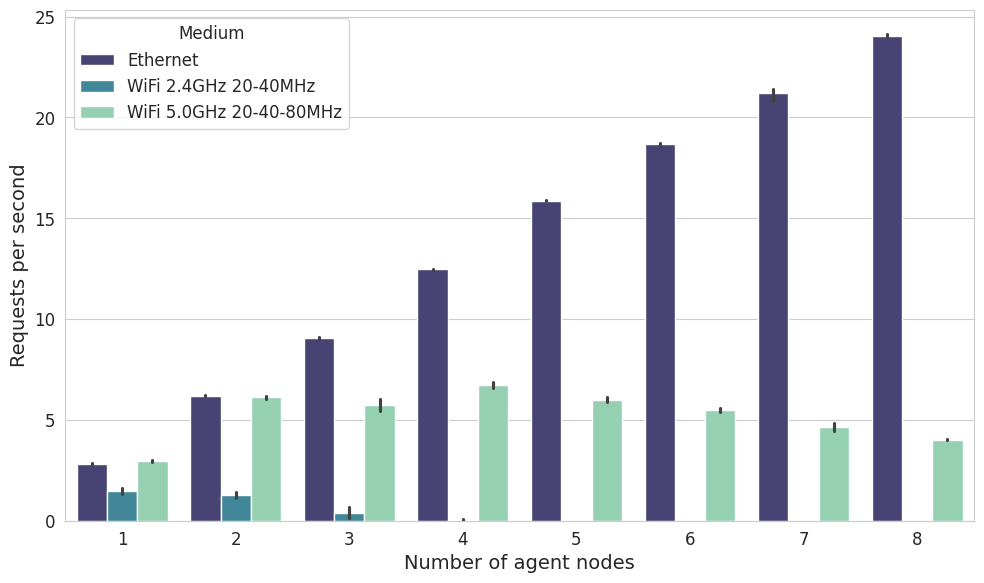

In [21]:
df_req_per_sec = pd.read_csv(exp_dir + "/request_per_sec.csv")
df_req_per_sec["Number of Agents"] = df_req_per_sec["Number of Nodes"] - 1


mediums = ["Ethernet", "WiFi 2.4GHz 20-40MHz", "WiFi 5.0GHz 20-40-80MHz"]

# for med in mediums:
#         df_exec_time_imp = df_req_per_sec[df_req_per_sec["Medium"] == med]
#         # Barplot comparison
#         plt.figure(figsize=(10, 6))
#         sns.set_style("whitegrid")
#         sns.barplot(data=df_exec_time_imp, x='Number of Agents', y='Request/s')

#         plt.ylim(bottom=0)
#         plt.tight_layout()
    
#         plt.savefig(graphs_req_per_sec_dir + "/barplot_Fairphone_" + experiment_name.replace(' ', '_') + "_" + med.replace(' ', '_') + ".pdf")
#         plt.show()


# Barplot comparison
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(data=df_req_per_sec, x='Number of Agents', y='Request/s',  hue="Medium", hue_order=mediums, palette=sns.color_palette('mako')[1::2])

plt.xlabel("Number of agent nodes")
plt.ylabel("Requests per second")
plt.ylim(bottom=0)
plt.tight_layout()

plt.savefig(graphs_req_per_sec_dir + "/barplot_Raspberry_req_per_sec" + experiment_name.replace(' ', '_') + ".pdf")
plt.show()